In [1]:
import numpy as np
import networkx as nx
from grakel import GraphKernel
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

## Creating a basic tree

In [4]:
def map_tree_simple(tree, root_node, depth=0):
    # initialize position dictionary
    positions = {}

    def traverse(node, x, y):
        nonlocal positions, depth
        positions[node] = (x, y) # assign position based on depth
        for child in tree[node]:
            # Adjust position slightly for children based on depth
            child_x, child_y = x + 0.1, y - 0.2 * depth
            traverse(child, child_x, child_y)
        depth += 1 # increment depth for child levels
    # start traversal from the root node
    traverse(root_node, 0.5, 0.8)

    return positions

tree = {
    "A": ["B", "C"],
    "B": ["D", "E"],
    "C": ["F", "G"],
    "D": [],
    "E": [],
    "F": [],
    "G": [],
}

positions = map_tree_simple(tree, "A")

for node, pos in positions.items():
    print(f"Node: {node}, Position: {pos}")

Node: A, Position: (0.5, 0.8)
Node: B, Position: (0.6, 0.8)
Node: D, Position: (0.7, 0.8)
Node: E, Position: (0.7, 0.6000000000000001)
Node: C, Position: (0.6, 0.19999999999999996)
Node: F, Position: (0.7, -0.40000000000000013)
Node: G, Position: (0.7, -0.6000000000000001)


## Creating a stereographic projection of a sample tree on a plane

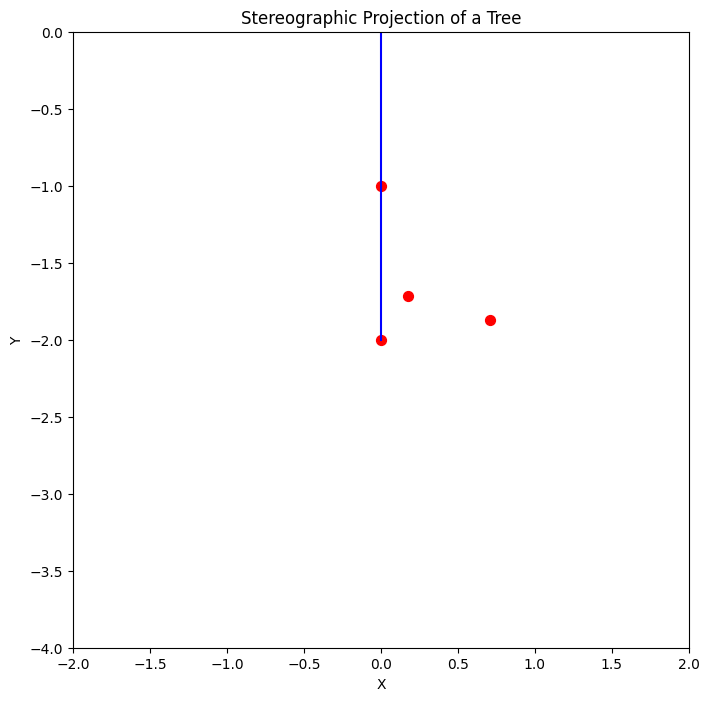

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Define a sample tree structure (adjacency matrix)
A = np.array([[0, 1, 0, 0],
              [1, 0, 1, 0],
              [0, 1, 0, 1],
              [0, 0, 1, 0]])
num_nodes = A.shape[0]

# Find the farthest node from the root (node 0) using BFS
def find_farthest_node(adjacency_matrix):
  visited = set()
  queue = [0]  # Start with root node

  while queue:
    current_node = queue.pop(0)
    visited.add(current_node)
    for neighbor in range(num_nodes):
      if neighbor not in visited and adjacency_matrix[current_node, neighbor] == 1:
        queue.append(neighbor)

  return current_node  # Return the farthest node

# Get the farthest node and its parent (assuming a rooted tree)
farthest_node = find_farthest_node(A)
parent_of_farthest = np.where(A[:, farthest_node] == 1)[0][0]

# Calculate normalized coordinates for the farthest and parent nodes
farthest_x = 0
farthest_y = -2  # Project farthest node to the bottom (y-axis)

parent_vec = np.array([A[parent_of_farthest, i] for i in range(num_nodes)])
parent_norm = np.linalg.norm(parent_vec)
parent_x = parent_vec[farthest_node] / parent_norm
parent_y = - (np.sqrt(4 - parent_x**2))  # Project parent using Pythagorean theorem

# Project remaining nodes using angle bisector method
node_coordinates = np.zeros((num_nodes, 2))
node_coordinates[farthest_node] = [farthest_x, farthest_y]
node_coordinates[parent_of_farthest] = [parent_x, parent_y]

for i in range(num_nodes):
  if i not in (farthest_node, parent_of_farthest):
    # Find neighbors of the current node
    neighbors = np.where(A[i, :] == 1)[0]
    if len(neighbors) == 1:  # Handle leaf nodes (only one neighbor)
      parent_coord = node_coordinates[neighbors[0]]
    else:
      # Calculate average coordinates of neighbors (excluding farthest node)
      neighbor_coords = node_coordinates[neighbors[neighbors != farthest_node]]
      parent_coord = np.mean(neighbor_coords, axis=0)

    # Bisect the angle between parent and farthest node
    bisector_x = (parent_coord[0] + farthest_x) / 2
    bisector_y = (parent_coord[1] + farthest_y) / 2

    # Project current node onto the bisector line
    node_coordinates[i] = [bisector_x, bisector_y]

# Plot the results
plt.figure(figsize=(8, 8))
plt.scatter(node_coordinates[:, 0], node_coordinates[:, 1], marker='o', color='red', s=50)  # Plot nodes as red circles
plt.plot([0, farthest_x], [0, farthest_y], color='blue')  # Line connecting root and farthest node (optional)
plt.xlim(-2, 2)
plt.ylim(-4, 0)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Stereographic Projection of a Tree")
plt.gca().set_aspect('equal')  # Maintain equal aspect ratio for circle
plt.show()


## Creating a stereographic projection of a sample tree on a sphere

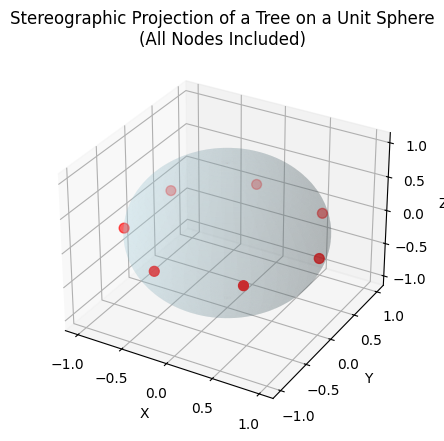

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define a sample tree structure as an adjacency matrix
adj_matrix = np.array([[0, 1, 1, 0, 0, 0, 0],
                        [0, 0, 0, 1, 1, 0, 0],
                        [0, 0, 0, 0, 0, 1, 1],
                        [0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0]])

# Project nodes using stereographic projection
def stereographic_projection(node_index):
    # Convert node index to spherical coordinates
    theta = node_index * (2 * np.pi / len(adj_matrix))
    phi = np.pi / 2

    # Convert spherical coordinates to Cartesian coordinates
    x = np.sin(phi) * np.cos(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(phi)

    return x, y, z

# Project all nodes using the function
projected_points = np.zeros((len(adj_matrix), 3))
for i in range(len(adj_matrix)):
    projected_points[i] = stereographic_projection(i)

# Plot the results
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the unit sphere (optional)
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x_sphere = np.outer(np.cos(u), np.sin(v))
y_sphere = np.outer(np.sin(u), np.sin(v))
z_sphere = np.outer(np.ones(len(u)), np.cos(v))
ax.plot_surface(x_sphere, y_sphere, z_sphere, color='lightblue', alpha=0.2)

# Plot the projected nodes on the sphere
ax.scatter(projected_points[:, 0], projected_points[:, 1], projected_points[:, 2], marker='o', color='red', s=50)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Stereographic Projection of a Tree on a Unit Sphere\n(All Nodes Included)")

plt.show()


### Defining roots & leaves

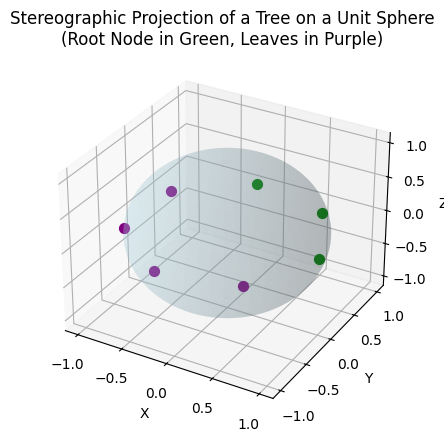

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define a tree structure as an adjacency matrix
adj_matrix = np.array([[0, 1, 1, 0, 0, 0, 0],
                        [0, 0, 0, 1, 1, 0, 0],
                        [0, 0, 0, 0, 0, 1, 1],
                        [0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0]])

# Function to check if a node is a leaf (has no outgoing connections)
def is_leaf(node_index):
    return np.sum(adj_matrix[node_index]) == 0

# Project nodes using stereographic projection
def stereographic_projection(node_index, parent=None):
    # Convert node index to spherical coordinates
    theta = node_index * (2 * np.pi / len(adj_matrix))
    phi = np.pi / 2

    # Convert spherical coordinates to Cartesian coordinates
    x = np.sin(phi) * np.cos(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(phi)

    return x, y, z

# Project all nodes using the function
projected_points = np.zeros((len(adj_matrix), 3))
for i in range(len(adj_matrix)):
    projected_points[i] = stereographic_projection(i)

# Plot the results
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the unit sphere (optional)
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x_sphere = np.outer(np.cos(u), np.sin(v))
y_sphere = np.outer(np.sin(u), np.sin(v))
z_sphere = np.outer(np.ones(len(u)), np.cos(v))
ax.plot_surface(x_sphere, y_sphere, z_sphere, color='lightblue', alpha=0.2)

# Plot the projected nodes on the sphere
for i, node in enumerate(projected_points):
    if is_leaf(i):
        ax.scatter(node[0], node[1], node[2], marker='o', color='purple', s=50)
    else:
        ax.scatter(node[0], node[1], node[2], marker='o', color='green', s=50)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Stereographic Projection of a Tree on a Unit Sphere\n(Root Node in Green, Leaves in Purple)")

plt.show()


## Stereographic projection using the tree made in the beginning

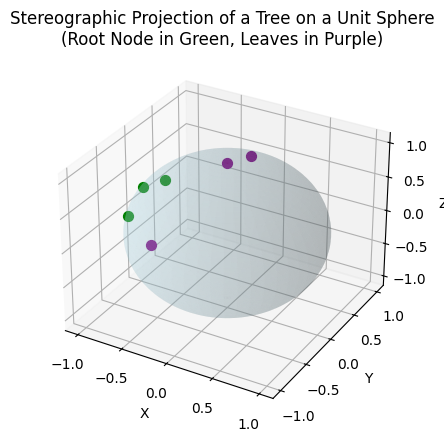

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the tree structure
tree = {
    'A': ['B', 'C'],
    'B': ['D'],
    'C': ['E', 'F'],
    'D': [],
    'E': [],
    'F': []
}

# Define the root node
root_node = 'A'

# Define a function to map the tree
def map_tree_simple(tree, root_node, depth=0):
    # Initialize position dictionary
    positions = {}

    def traverse(node, x, y):
        nonlocal positions, depth
        positions[node] = (x, y)  # Assign position based on depth
        for child in tree[node]:
            # Adjust position slightly for children based on depth
            child_x, child_y = x + 0.1, y - 0.2 * depth
            traverse(child, child_x, child_y)
        depth += 1  # Increment depth for child levels

    # Start traversal from the root node
    traverse(root_node, 0.5, 0.8)

    return positions

# Function to check if a node is a leaf (has no outgoing connections)
def is_leaf(node, tree):
    return len(tree[node]) == 0

# Project nodes using stereographic projection
def stereographic_projection(positions, node, parent=None):
    # Convert position to spherical coordinates
    theta = positions[node][0] * (2 * np.pi)
    phi = positions[node][1] * (np.pi / 2)

    # Convert spherical coordinates to Cartesian coordinates
    x = np.sin(phi) * np.cos(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(phi)

    return x, y, z

# Map the tree
positions = map_tree_simple(tree, root_node)

# Plot the results
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the unit sphere (optional)
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x_sphere = np.outer(np.cos(u), np.sin(v))
y_sphere = np.outer(np.sin(u), np.sin(v))
z_sphere = np.outer(np.ones(len(u)), np.cos(v))
ax.plot_surface(x_sphere, y_sphere, z_sphere, color='lightblue', alpha=0.2)

# Plot the projected nodes on the sphere
for node in positions:
    if is_leaf(node, tree):
        ax.scatter(*stereographic_projection(positions, node), marker='o', color='purple', s=50)
    else:
        ax.scatter(*stereographic_projection(positions, node), marker='o', color='green', s=50)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Stereographic Projection of a Tree on a Unit Sphere\n(Root Node in Green, Leaves in Purple)")

plt.show()
